In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, callback
from optuna.integration import XGBoostPruningCallback
import mlflow
from utils.metrics import Metrics_df,print_metrics, precision, recall, f1
import glob
from tqdm import tqdm
from utils.forest_infer import pred_multi


In [2]:


import pandas as pd
from sklearn.metrics import roc_auc_score
from Config import config
import warnings
warnings.filterwarnings("ignore")
import optuna  # pip install optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime
import gc
import pickle
import tempfile

In [3]:
from lightgbm.basic import LightGBMError
from lightgbm import LGBMClassifier, early_stopping, log_evaluation, Booster
from sklearn.metrics import roc_auc_score
import os

# Loading data and group split

In [4]:
# df_pairs = pd.read_csv("/workspace/Training_data/training/Full_training_data.csv")
# df_pairs = df_pairs.sample(frac=1).reset_index(drop=True)
# kf = GroupKFold(n_splits=5)
# for i, (trn_idx, val_idx) in enumerate(kf.split(df_pairs, df_pairs["placeId1"], df_pairs["placeId1"])):
#     df_pairs.loc[val_idx, "fold"] = i
# df_pairs["fold"].value_counts()
# df_pairs.to_csv("/workspace/Training_data/training/Full_training_data_fold.csv",index=None)

# Loading data

In [5]:
df_pairs = pd.read_csv("/workspace/Training_data/training/Full_training_data_fold_v4_without_categories.csv")

In [6]:
features = ['similarity', 'haversine', 'name_davies',
       'name_leven', 'name_dice', 'name_jaro', 'name_set_ratio',
       'street_davies', 'street_leven', 'street_jaro', 'email_davies',
       'email_leven', 'email_jaro', 'url_davies', 'url_leven', 'url_jaro',
       'brands_davies', 'brand_leven', 'brand_jaro', 'phone_lcs',
       'subcat_WRatio', 'subcat_ratio', 'subcat_token_set_ratio',
       'Is_direction_match_0', 'Is_direction_match_1', 'Is_direction_match_2',
       'Is_house_match_0', 'Is_house_match_1', 'Is_house_match_2',
       'Is_category_match_0', 'Is_category_match_1', 'Is_subcategory_match_0',
       'Is_subcategory_match_1', 'Is_subcategory_match_2', 'Is_brand_match_0',
       'Is_brand_match_1', 'Is_brand_match_2', 'Is_brand_match_3',
       'Is_related_cat_0', 'Is_related_cat_1', 'Is_name_number_match_0',
       'Is_name_number_match_1', 'Is_name_number_match_2',
       'Is_name_number_match_3', 'is_phone_match_1', 'is_phone_match_2',
       'is_phone_match_3', 'is_phone_match_4', 'Is_email_match_0',
       'Is_email_match_1', 'Is_email_match_2', 'Is_url_match_0',
       'Is_url_match_1', 'Is_url_match_2']

In [7]:
params =        {
            "learning_rate": 0.05,
            'max_depth': 14,
            'min_child_weight': 1.24,
            'reg_alpha': 0.2764,
            'reg_lambda': 9.80e-07,
            "colsample_bytree": 0.56,
            "gamma":0.115,
            "subsample": 0.80
        }

In [8]:
for fold in [0,1,2,3,4]:

    model = XGBClassifier(
        **params,
        n_estimators=4000,
        objective="binary:logistic",
        eval_metric="auc",
        tree_method="gpu_hist",
        predictor="gpu_predictor",
        use_label_encoder=False,
        random_state=42,
        enable_categorical=True,
    )
    es = callback.EarlyStopping(
        rounds=100,
        min_delta=1e-5,
        save_best=True,
        maximize=True,
        data_name="validation_0",
        metric_name="auc",
    )

    model.fit(df_pairs[df_pairs["fold"]!=fold][features],df_pairs[df_pairs["fold"]!=fold]["duplicate_flag"],
    eval_set=[(df_pairs[df_pairs["fold"]==fold][features], df_pairs[df_pairs["fold"]==fold]["duplicate_flag"])],verbose=100,
    callbacks=[es])
    model.save_model("/workspace/models/" + f"xgboost_dedup_v2_{fold}.json")



[0]	validation_0-auc:0.99820
[100]	validation_0-auc:0.99991
[200]	validation_0-auc:0.99994
[273]	validation_0-auc:0.99994
[0]	validation_0-auc:0.99853
[100]	validation_0-auc:0.99992
[200]	validation_0-auc:0.99995
[277]	validation_0-auc:0.99995
[0]	validation_0-auc:0.99831
[100]	validation_0-auc:0.99992
[200]	validation_0-auc:0.99995
[300]	validation_0-auc:0.99995
[314]	validation_0-auc:0.99995
[0]	validation_0-auc:0.99838
[100]	validation_0-auc:0.99992
[200]	validation_0-auc:0.99994
[263]	validation_0-auc:0.99995
[0]	validation_0-auc:0.99801
[100]	validation_0-auc:0.99992
[200]	validation_0-auc:0.99994
[300]	validation_0-auc:0.99995
[301]	validation_0-auc:0.99995


# Inference validation

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 15)
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams["legend.loc"] = 'best'


<AxesSubplot: >

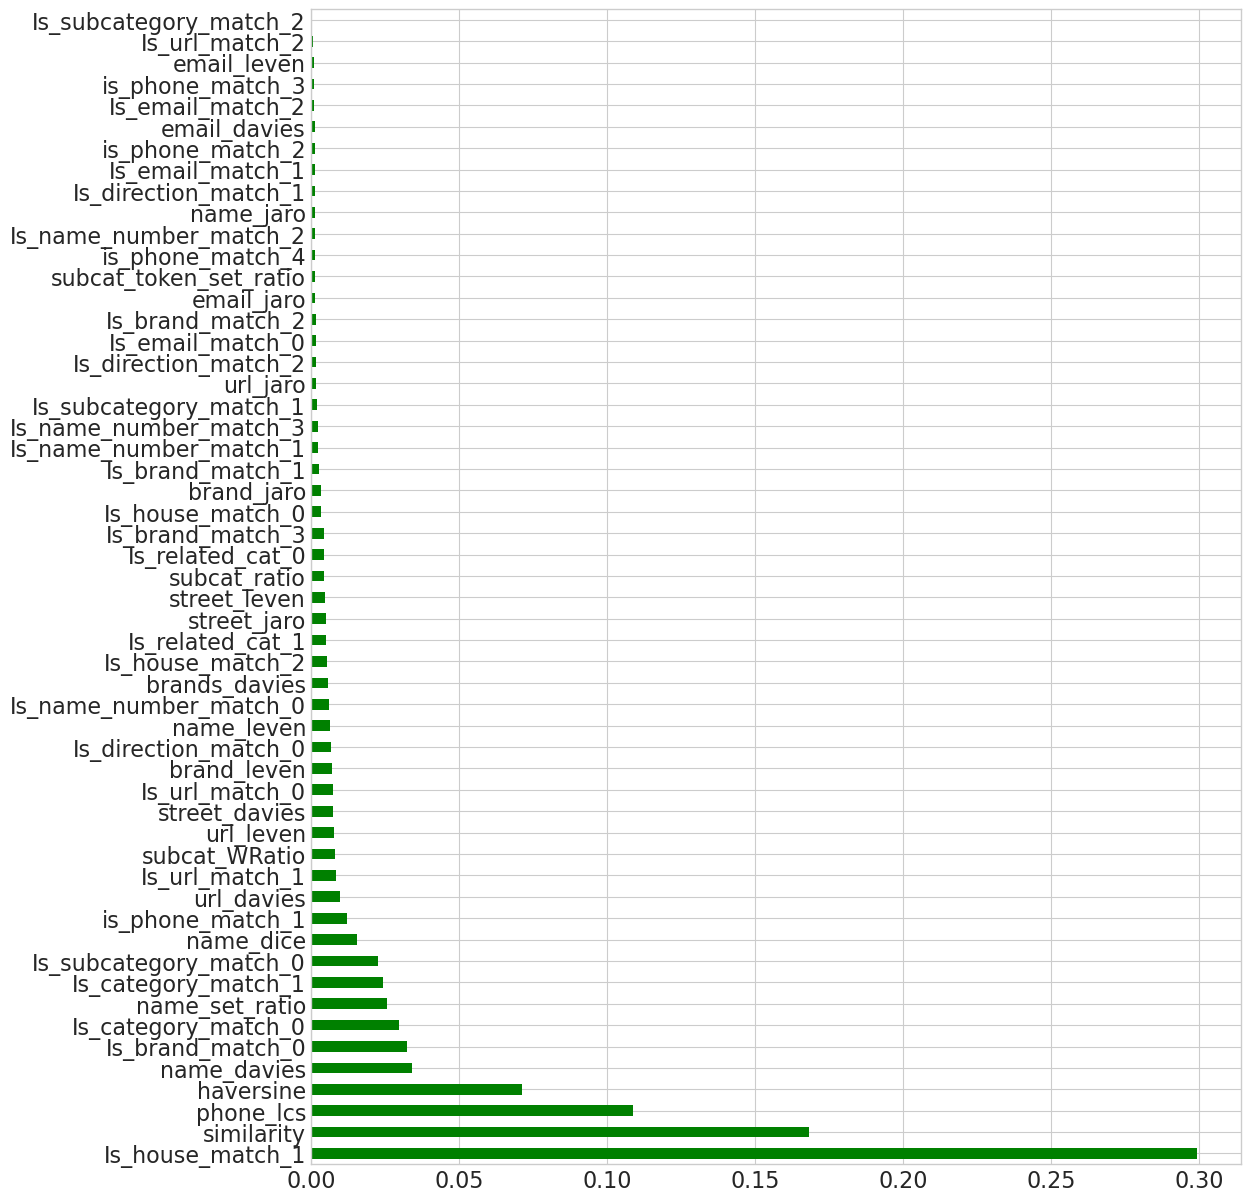

In [12]:
feat_importances = pd.Series(model.feature_importances_, index=model.feature_names_in_)
feat_importances.nlargest(70).plot(kind='barh', color='green')


In [13]:
models = glob.glob(f"/workspace/models/xgboost_dedup_v2_*")

In [14]:
models

['/workspace/models/xgboost_dedup_v2_0.json',
 '/workspace/models/xgboost_dedup_v2_1.json',
 '/workspace/models/xgboost_dedup_v2_2.json',
 '/workspace/models/xgboost_dedup_v2_3.json',
 '/workspace/models/xgboost_dedup_v2_4.json']

In [15]:
def pred_multi_xgb(model_file,df):
    xgb_model = XGBClassifier()
    xgb_model.load_model(model_file)
    prediction = xgb_model.predict_proba(df)[:, 1]
    del xgb_model
    gc.collect()
    return prediction

In [16]:
ltable_id = []
rtable_id = []
duplicate_flag = []
ltable_id = ltable_id + list(df_pairs["placeId1"])
rtable_id = rtable_id + list(df_pairs["placeId2"])

duplicate_flag = duplicate_flag + list(df_pairs["duplicate_flag"])
all_pred = []
for model_file in tqdm(models):
    prediction = pred_multi_xgb(model_file,df_pairs[features])
    all_pred.append(prediction)

100%|██████████| 5/5 [00:15<00:00,  3.11s/it]


In [17]:
df = pd.DataFrame(list(
    zip(ltable_id, rtable_id, all_pred[0], all_pred[1], all_pred[2],all_pred[3],all_pred[4],duplicate_flag)),
                columns=['ltable_id', 'rtable_id', 'prediction1','prediction2', 'prediction3','prediction4','prediction5','duplicate_flag'])
df["prediction"] = df["prediction1"] + df["prediction2"] + df["prediction3"] + df["prediction4"] + df["prediction5"]
df["prediction"] = df["prediction"] / 5

0.9999975798965374


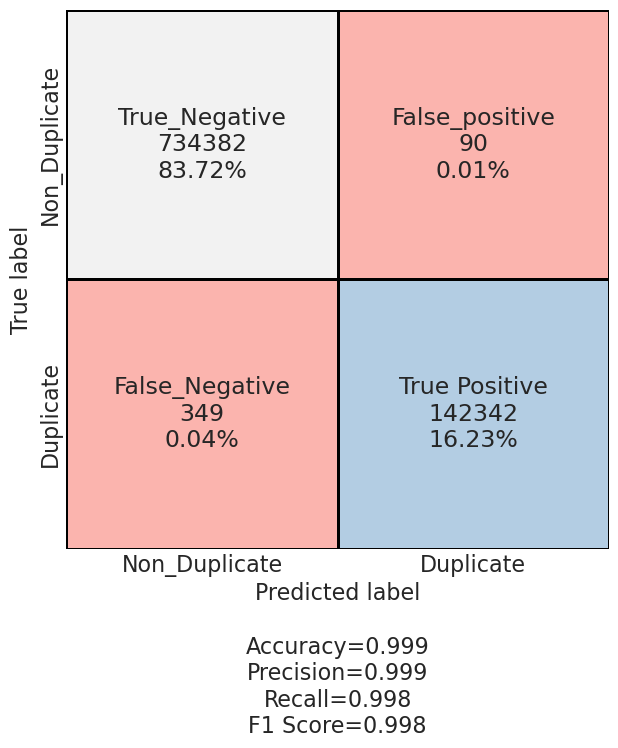

In [18]:
fig_conf= print_metrics(df["duplicate_flag"],df["prediction"])